In [2]:
import os

from object_detection.utils import config_util
from object_detection.builders import model_builder
import numpy as np
import tensorflow as tf


os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [3]:
## 目前验证的是ssd_eficientd0
## 模型配置文件 
configs = config_util.get_configs_from_pipeline_file('/home/create/jing/tfmodels/tf_models2/research/object_detection/weights/efficientdet_d0_coco17_tpu-32/pipeline.config')
## 构建模型
detection_model = model_builder.build(configs['model'], is_training=False)
## 加载ckpt权重
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore('/home/create/jing/tfmodels/tf_models2/research/object_detection/weights/arm/ckpt-34').expect_partial()
class MyModel(tf.keras.Model):
    def __init__(self, model):
        super(MyModel, self).__init__()
        self.model = model
        ## 此处输入维度应与tflite模型输入维度要求图片尺寸一致
        self.seq = tf.keras.Sequential([
            tf.keras.Input([512,512,3], 1),
        ])

    def call(self, x):
        x = self.seq(x)
        images, shapes = self.model.preprocess(x)
        prediction_dict = self.model.predict(images, shapes)
        detections = self.model.postprocess(prediction_dict, shapes)
        boxes = detections['detection_boxes']
        scores = detections['detection_scores'][:,:,None]
        classes = detections['detection_classes'][:,:,None]
        combined = tf.concat([boxes, classes, scores], axis=2)
        return combined
## 搭建keras模型
km = MyModel(detection_model)
## 预测模型（注意输入维度）
y = km.predict(np.random.random((1,512,512,3)).astype(np.float32))
## 转换为tflite模型
converter = tf.lite.TFLiteConverter.from_keras_model(km)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]
## 量化  
##训练后动态范围量化 27M-->17M
converter.optimizations = [tf.lite.Optimize.DEFAULT]

converter.experimental_new_converter = True
converter.allow_custom_ops = False
tflite_model = converter.convert()

open('model_dynamic.tflite', 'wb').write(tflite_model)

17218608

In [29]:
## 使用tflite预测

In [4]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter('model_dynamic.tflite')
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the TensorFlow Lite model on random input data.
input_shape = input_details[0]['shape']
from PIL import Image, ImageDraw, ImageFont
image_path = r'/home/create/jing/tfmodels/tf_models2/research/object_detection/data/arm/val/images/aa86220c12d32594cae498ab57d21b57_00063.jpg'
image = Image.open(image_path)
image_pred = image.resize((input_shape[2],input_shape[2]), Image.ANTIALIAS)
image_pred = np.asarray(image_pred).astype('float32')
image_pred = np.expand_dims(image_pred,axis=0)
print(image_pred.shape)
interpreter.set_tensor(input_details[0]['index'], image_pred)

interpreter.invoke()
print('input_details,output_details',input_details,output_details)
tflite_results = interpreter.get_tensor(output_details[0]['index'])
print('tflite_results',tflite_results)

(1, 512, 512, 3)
input_details,output_details [{'name': 'input_1', 'index': 0, 'shape': array([  1, 512, 512,   3], dtype=int32), 'shape_signature': array([  1, 512, 512,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}] [{'name': 'Identity', 'index': 66650, 'shape': array([], dtype=int32), 'shape_signature': array([], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
tflite_results [[[0.01261612 0.26911277 0.15312839 0.36570156 2.         0.9988036 ]
  [0.25351408 0.36685002 0.34527943 0.42879957 0.         0.99522936]
  [0.01261612 0.26911277 0.15312839 0.36570156 1.         0.02653491]
  [0.01261612 0.26911277 0.1531283

In [5]:
tflite_results.shape

(1, 100, 6)

In [6]:
output_details

[{'name': 'Identity',
  'index': 66650,
  'shape': array([], dtype=int32),
  'shape_signature': array([], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [7]:
output_details = interpreter.get_output_details()[0]
tensor = np.squeeze(interpreter.get_tensor(output_details['index']))

In [8]:
tensor,tensor.shape

(array([[0.01261612, 0.26911277, 0.15312839, 0.36570156, 2.        ,
         0.9988036 ],
        [0.25351408, 0.36685002, 0.34527943, 0.42879957, 0.        ,
         0.99522936],
        [0.01261612, 0.26911277, 0.15312839, 0.36570156, 1.        ,
         0.02653491],
        [0.01261612, 0.26911277, 0.15312839, 0.36570156, 0.        ,
         0.02440974],
        [0.00762923, 0.2986524 , 0.09425913, 0.37096018, 2.        ,
         0.01998085],
        [0.25199866, 0.36583638, 0.34632647, 0.42972434, 1.        ,
         0.01957542],
        [0.        , 0.48125437, 0.9766545 , 1.        , 1.        ,
         0.01265234],
        [0.33938032, 0.77401483, 1.        , 1.        , 1.        ,
         0.01111785],
        [0.26894236, 0.3837783 , 0.36886764, 0.43628225, 0.        ,
         0.01046401],
        [0.01227391, 0.6998422 , 0.75208366, 1.        , 1.        ,
         0.0099166 ],
        [0.33938032, 0.77401483, 1.        , 1.        , 2.        ,
         0.00964126],

In [9]:
boxes = tensor[:,:4]
classes = tensor[:,4]
scores = tensor[:,5]

results = []
for i in range(len(scores)):
    if scores[i] >= 0.5:
        result = {
            'bounding_box': boxes[i],
            'class_id': classes[i],
            'score': scores[i]
        }
        results.append(result)

In [10]:
results

[{'bounding_box': array([0.01261612, 0.26911277, 0.15312839, 0.36570156], dtype=float32),
  'class_id': 2.0,
  'score': 0.9988036},
 {'bounding_box': array([0.25351408, 0.36685002, 0.34527943, 0.42879957], dtype=float32),
  'class_id': 0.0,
  'score': 0.99522936}]

In [11]:
import cv2
labels = ['lighter','car','arm_end']
result_size = len(results)
show_image = cv2.imread(image_path)
for idx, obj in enumerate(results):
    print(obj)
    # Prepare image for drawing
    draw = ImageDraw.Draw(image)
    size = np.asarray(image).shape
    # Prepare boundary box
    ymin, xmin, ymax, xmax = obj['bounding_box']
    xmin = int(xmin * size[1])
    xmax = int(xmax * size[1])
    ymin = int(ymin * size[0])
    ymax = int(ymax * size[0])
    
    cv2.rectangle(show_image, (xmin,ymin), (xmax,ymax), (25,0,255), 4)

    # Annotate image with label and confidence score
    display_str = labels[int(obj['class_id'])] + ": " + str(round(obj['score']*100, 2)) + "%"
  

{'bounding_box': array([0.01261612, 0.26911277, 0.15312839, 0.36570156], dtype=float32), 'class_id': 2.0, 'score': 0.9988036}
{'bounding_box': array([0.25351408, 0.36685002, 0.34527943, 0.42879957], dtype=float32), 'class_id': 0.0, 'score': 0.99522936}


In [12]:
np.asarray(image).shape

(544, 960, 3)

In [15]:
im = Image.fromarray(show_image[:,:,[2,0,1]])

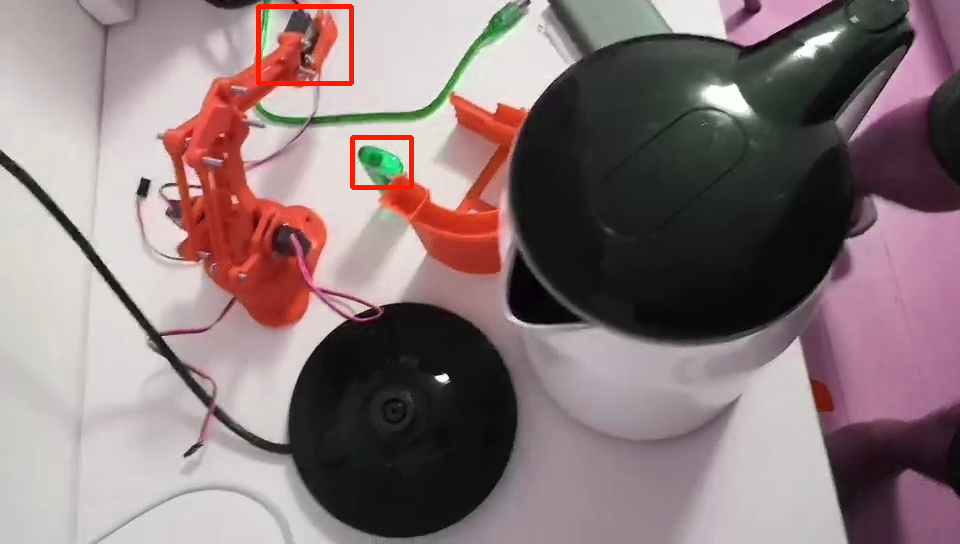

In [16]:
im